In [ ]:
! pip install transformers
! pip install pyspark

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
# from matplotlib import pyplot as plt

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import Dataset
import torch
from torch.utils.data import DataLoader

In [78]:
import pyspark
from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# load models
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Read Data

In [6]:
df = pd.read_csv("data/2023-02-10/reddit.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6464 entries, 0 to 6463
Data columns (total 97 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   subreddit                      6464 non-null   object 
 1   selftext                       3633 non-null   object 
 2   author_fullname                6407 non-null   object 
 3   gilded                         6464 non-null   int64  
 4   title                          6464 non-null   object 
 5   link_flair_richtext            6464 non-null   object 
 6   subreddit_name_prefixed        6464 non-null   object 
 7   hidden                         6464 non-null   bool   
 8   pwls                           6464 non-null   int64  
 9   link_flair_css_class           4540 non-null   object 
 10  thumbnail_height               2958 non-null   float64
 11  top_awarded_type               0 non-null      float64
 12  hide_score                     6464 non-null   b

In [ ]:
df[df['selftext']=="[removed]"][['title']].head()

,title
9,Wycoff accumulation?
16,TIENES MIEDO DE QUE BTC BAJE? ARE YOU AFRAID O...
18,Que les parece esta grafica?
23,Trading en la apertura del mercado el viernes
24,any good stocks for a first time investor?


In [24]:
na_cond = (df['selftext'].isna()) | (df['title'].isna())
df = df[~na_cond]

In [175]:
df_sample = df.iloc[:20].reset_index()

In [5]:
df_sample.to_csv("data/toy.csv",index=False)
# df_sample = pd.read_csv("/content/drive/MyDrive/MSDS697/toy.csv")

NameError: name 'df_sample' is not defined

# Preprocessing on text

In [7]:
df_sample = pd.read_csv("data/toy.csv")

In [8]:
df_sample["fulltext"] = df_sample['title'] + "\n" + df_sample['selftext']
df_sample["fulltext"][0]

'500k to invest in the most R way!\nI got 500k in various 401ks, Roths, and Brokerage accounts. Hoping to get to $1mil in 5 years. What’s the most smooth brain way to invest to get there, based on those investment limitations?'

In [25]:
df['fulltext'] = df['title'] + "\n" + df['selftext']

## Filter

In [14]:
lines = ["AAPL and MSFT are doing well", "App development", "Invest in AAPL"]
df_lines = pd.DataFrame({"lines":lines})
tickers = ["AAPL", "MSFT"]

In [16]:
df_lines['lines'].str.contains("|".join(stickers), case=False)

0     True
1    False
2     True
Name: lines, dtype: bool

In [173]:
tickers = pd.read_csv("data/Russell 3000 - Google Spreadsheet - Sheet 1.csv")['Ticker'].to_list()
len(tickers)

2995

In [36]:
df['fulltext'].str.contains("|".join(tickers), case=False)

1       True
2       True
4       True
5       True
6       True
        ... 
6459    True
6460    True
6461    True
6462    True
6463    True
Name: fulltext, Length: 3633, dtype: bool

## Tokenization Test

Test on tokenizer limit

In [ ]:
for text in df_sample['fulltext']:
  token_ids = tokenizer.encode(text)
  print(len(token_ids))

61
3024
284
75
48
11
44
2673
25
62
14
2688
19
14
43
34
11
14
67
85


Will occasionally come across posts longer than 500 tokens.

How to deal with it now: divide by new line and truncate by 512

In [ ]:
# estimate for all
tokens_len = []
for fulltext in df['fulltext']:
  paragraphs = fulltext.split("\n")
  for p in paragraphs:
    token_ids = tokenizer.encode(p)
    tokens_len.append(len(token_ids))

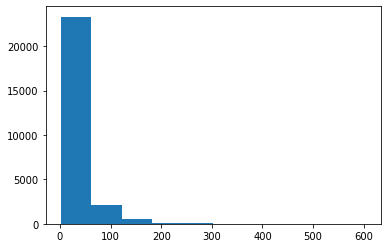

In [ ]:
tokens_len = np.array(tokens_len)
plt.hist(tokens_len);

In [ ]:
(tokens_len > 512).mean()

7.666360012266176e-05

After truncating with newline, most paragraphs are less than 512 tokens

# Predict One (Long) Sentence

In [9]:
# try one long sentence
long_text_eg = df_sample['fulltext'][1]
long_text_eg

'The Castle on the Sand\n \n\n***TLDR: Kenneth Griffin and Citadel are running the single most profitable high-frequency market manipulation schemes in modern history. However, high-frequency trading comes with a significant number of risks that can cause flash crashes and general market failure. I also believe that Citadel has been executing a majority of its trades by using shares that it does not own, or by taking advantage of failures in the integrity of exchanges.***\n\n**PREFACE**\n\nSince the origination of the US stock exchange in 1792, countless investors have tried their hands at identifying profitable strategies for building their wealth. In the beginning, these strategies were relatively straightforward. First, find a business that you believe in. Next, take your own hard-earned money and extend a show of faith to the business that you believe will generate substantial returns. Then, after years of development and growth, reap the rewards of your faith through returns on yo

In [36]:
for c in chunks:
    print(len(c.split()))

415
481
456


In [40]:
long_text_ls = long_text_eg.split("\n")

In [41]:
# many are meaningless whitespaces
long_text_ls = [x.strip() for x in long_text_ls]
len(long_text_ls)

116

In [43]:
# remove white spaces
long_text_ls = [x for x in long_text_ls if x != '']
len(long_text_ls)

58

In [38]:
# split inanother way
ps = long_text_eg.split('\n')
ps = [p.strip() for p in ps]
ps = [p for p in ps if p != ""]
ps_token = [p.split() for p in ps]
chunks = []
current_chunk, current_length = '', 0
for i in range(len(ps)):
    p_len = len(ps_token[i]) + 1
    if current_length + p_len < 500:
        current_chunk += ps[i] + "\n"
        current_length += p_len
    else:
        chunks.append(current_chunk)
        current_chunk, current_length = ps[i], p_len

In [39]:
# tokenized = tokenizer(long_text_ls, padding=True, truncation=True, return_tensors="pt")
tokenized = tokenizer(chunks, padding=True, truncation=True, return_tensors="pt")

In [43]:
ds = Dataset.from_dict(tokenized)

In [44]:
dataloader = DataLoader(ds, batch_size=8, collate_fn=data_collator)

In [47]:
outputs = []
for batch in dataloader:
    # print({k:v.shape for k,v in batch.items()})
    logits = model(**batch).logits
    probabilities = torch.softmax(logits, dim=1)
    outputs.append(probabilities.cpu().detach().numpy())
final = np.concatenate(outputs)

In [46]:
model.config.id2label

{0: 'positive', 1: 'negative', 2: 'neutral'}

In [49]:
final[final[:,2] < 0.5]

array([[0.01714356, 0.7390963 , 0.24376021]], dtype=float32)

In [48]:
# test for short sentence
short_text_ls = long_text_ls[:3]
tokenized = tokenizer(short_text_ls, padding=True, truncation=True, return_tensors="pt")
ds = Dataset.from_dict(tokenized)
dataloader = DataLoader(ds, batch_size=8, collate_fn=data_collator)
for batch in dataloader:
    batch.keys()
    break

## Functions

In [55]:
def split_lines(text):
    text_ls = text.split("\n")
    text_ls = [x.strip() for x in text_ls]
    text_ls = [x for x in text_ls if x != '']
    return text_ls

In [75]:
def split_paragraphs(long_text, limit = 500):
    """Split long texts into paragraphs. With upper limit of n tokens, do as few split as possible
    """
    ps = long_text.split('\n')
    ps = [p.strip() for p in ps]
    ps = [p for p in ps if p != ""]
    ps_token = [p.split() for p in ps]
    chunks = []
    current_chunk, current_length = '', 0
    for i in range(len(ps)):
        p_len = len(ps_token[i]) + 1
        if (current_length + p_len) < limit:
            current_chunk += ps[i] + "\n"
            current_length += p_len
        else:
            chunks.append(current_chunk.strip())
            current_chunk, current_length = ps[i], p_len
    chunks.append(current_chunk.strip())
    return chunks

In [57]:
def pred_batch(dataloader):
    """Make prediction in batched way to prevent RAM overload
    """
    outputs = []
    for batch in dataloader:
        with torch.no_grad():
            logits = model(**batch).logits
            probs = torch.softmax(logits, dim=1)
            outputs.append(probs)
    return torch.cat(outputs, dim=0)

In [60]:
# to functions
def pred_one_sentence(long_setence, filter=0.5):
    text_ls = split_paragraphs(long_setence)
    tokenized = tokenizer(text_ls, padding=True, truncation=True, return_tensors="pt")
    ds = Dataset.from_dict(tokenized)
    dataloader = DataLoader(ds, batch_size=8, collate_fn=data_collator)
    probs = pred_batch(dataloader)
    # if filter is not None:
    #     probs = probs[probs[:,2]<=filter]
    return probs

# Predict Multiple Setences

Strategy: 
- no parallelization: for each sentence, split, tokenize, turn to batches, predict
- parallelization: split at first, keep id as itenfier, collectively turn to batches, predict

In [147]:
df_sample2 = df_sample.apply(split_lines,axis=1).explode('paragraph').set_index("id",drop=True)
df_sample2.head()

,fulltext
id,
10tottd,500k to invest in the most R way!
10tottd,"I got 500k in various 401ks, Roths, and Broker..."
10toqua,The Castle on the Sand
10toqua,***TLDR: Kenneth Griffin and Citadel are runni...
10toqua,**PREFACE**


In [168]:
tokenized = tokenizer(df_sample2['paragraph'].to_list(), padding=True, truncation=True, return_tensors="pt")

In [170]:
ds = Dataset.from_dict(tokenized)
ds

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 207
})

In [171]:
dataloader = DataLoader(ds, batch_size=8, collate_fn=data_collator)

In [176]:
final = pred_batch(dataloader)
final.shape

(207, 3)

## Functions

In [ ]:
def pred_multiple(df_input):
    """
    arguments:
    - df: a pandas dataframe of two columns: id and fulltext, each row is a reddit post
    """
    # split post to paragraphs
    df_split = df_input.apply(split_lines,axis=1).explode('paragraph').set_index("id",drop=True)
    # tokenize each paragraph
    tokenized = tokenizer(df_split['paragraph'].to_list(), padding=True, truncation=True, return_tensors="pt")
    # dict -> dataset -> dataloader
    ds = Dataset.from_dict(tokenized)
    dataloader = DataLoader(ds, batch_size=8, collate_fn=data_collator)
    preds = pred_batch(dataloader)
    # pred is in the same size as df_split
    df_split[['positive','negative','neutral']] = preds
    return df_split

# Application

In [61]:
# test function
pred_one_sentence(long_text_eg)

tensor([[0.0450, 0.0462, 0.9088],
        [0.0171, 0.7391, 0.2438],
        [0.0536, 0.1999, 0.7464]])

In [129]:
df_list = []
for folder in os.listdir("data"):
    data_file_path = os.path.join("data/", folder, 'reddit.csv')
    if os.path.isfile(data_file_path):
        df = pd.read_csv(data_file_path)
        df_list.append(df)
df_total_raw = pd.concat(df_list)

In [211]:
df_total_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26731 entries, 0 to 5056
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   subreddit                      26731 non-null  object 
 1   selftext                       15000 non-null  object 
 2   author_fullname                26495 non-null  object 
 3   gilded                         26731 non-null  int64  
 4   title                          26731 non-null  object 
 5   link_flair_richtext            26731 non-null  object 
 6   subreddit_name_prefixed        26731 non-null  object 
 7   hidden                         26731 non-null  bool   
 8   pwls                           26730 non-null  float64
 9   link_flair_css_class           18043 non-null  object 
 10  thumbnail_height               11604 non-null  float64
 11  top_awarded_type               0 non-null      float64
 12  hide_score                     26731 non-null  

In [204]:
df_total_raw['utc_datetime_str'].min(), df_total_raw['utc_datetime_str'].max()

('2023-02-03 19:29:40', '2023-03-03 19:19:48')

In [212]:
df_total_raw.to_csv("data/reddit_all_dates.csv",index=False)

In [142]:
df_total = df_total_raw[['subreddit','id','title','selftext']].copy()
df_total['post_id'] = df_total['subreddit'] + "_" + df_total["id"]
# drop duplicates
df_total = df_total.drop_duplicates(subset=['post_id'])
# replace removed with empty string
df_total['selftext'] = df_total['selftext'].str.replace("[removed]","")
df_total = df_total.fillna("")
# filter empty posts
cond = (df_total['title'] != "") | (df_total['selftext'] != "")
df_total = df_total[cond]
# create fulltext
df_total['fulltext'] = df_total['title'] + "\n" + df_total['selftext']
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13855 entries, 0 to 5056
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  13855 non-null  object
 1   id         13855 non-null  object
 2   title      13855 non-null  object
 3   selftext   13855 non-null  object
 4   post_id    13855 non-null  object
 5   fulltext   13855 non-null  object
dtypes: object(6)
memory usage: 757.7+ KB


In [150]:
df_total = df_total[['post_id','id','fulltext']]

In [181]:
# filter
df_filter = df_total[df_total['fulltext'].str.contains("|".join(tickers))]

In [182]:
df_filter.shape

(12538, 3)

## PySpark

In [164]:
pred_one_sentence_vec = udf(lambda x: pred_one_sentence(x).tolist(), ArrayType(ArrayType(FloatType())))
def sentiment_vectorizer(spark_df, large = False): 
    sentiment_df = spark_df.withColumn("vectors", pred_one_sentence_vec(col("fulltext")))
    return sentiment_df

In [147]:
ss.stop()

In [156]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
ss = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.driver.memory", "14g") \
    .config("spark.executor.memory", "14g") \
    .getOrCreate()

In [157]:
executor_memory = ss.sparkContext.getConf().get('spark.executor.memory')
executor_memory

'14g'

In [171]:
ss.sparkContext.uiWebUrl

'http://localhost:4040'

### Sample

In [163]:
df_sample_sp = ss.createDataFrame(df_sample[['id','title','selftext','fulltext']])
df_sample_sp.show(2)

+-------+--------------------+--------------------+--------------------+
|     id|               title|            selftext|            fulltext|
+-------+--------------------+--------------------+--------------------+
|10tottd|500k to invest in...|I got 500k in var...|500k to invest in...|
|10toqua|The Castle on the...| \n\n***TLDR: Ken...|The Castle on the...|
+-------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [165]:
df_pred_toy = sentiment_vectorizer(df_sample_sp)
df_pred_toy.show(2)

+-------+--------------------+--------------------+--------------------+--------------------+
|     id|               title|            selftext|            fulltext|             vectors|
+-------+--------------------+--------------------+--------------------+--------------------+
|10tottd|500k to invest in...|I got 500k in var...|500k to invest in...|[[0.20758328, 0.0...|
|10toqua|The Castle on the...| \n\n***TLDR: Ken...|The Castle on the...|[[0.056986123, 0....|
+-------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [166]:
df_pred_toy.write.format("json").mode("overwrite").option("header","ture").save("preds/reddit_toy.json")

### Whole Dataset

In [183]:
# df_total_sp = ss.createDataFrame(df_total)
# df_total_sp.unpersist()

DataFrame[post_id: string, id: string, fulltext: string]

In [188]:
df_filter_sp = ss.createDataFrame(df_filter)
df_filter_sp.show(1)
df_filter_sp = df_filter_sp.cache()

+--------------------+-------+--------------------+
|             post_id|     id|            fulltext|
+--------------------+-------+--------------------+
|wallstreetbets_11...|114bx75|Short MSFT? Chat ...|
+--------------------+-------+--------------------+
only showing top 1 row



In [190]:
df_pred_sp = sentiment_vectorizer(df_filter_sp)
df_pred_sp = df_pred_sp.cache()
df_pred_sp.write.format("json").mode("overwrite").option("header","ture").save("preds/reddit_pred.json")

In [193]:
df_preds = df_pred_sp.toPandas()

In [196]:
df_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12538 entries, 0 to 12537
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   post_id   12538 non-null  object
 1   id        12538 non-null  object
 2   fulltext  12538 non-null  object
 3   vectors   12538 non-null  object
dtypes: object(4)
memory usage: 391.9+ KB


In [195]:
df_preds.to_csv("preds/reddit_pred.json/reddit_preds_vectors.csv",index=False)